# Neural Radiance Field (NeRF)
Victor Ludvig

<br>

<!DOCTYPE html>
<html lang="en">
<head>
<meta charset="UTF-8">
<meta name="viewport" content="width=device-width, initial-scale=1.0">
<title>Horizontal Videos</title>
<style>
  .video-container {
    display: flex;
    justify-content: center; /* Align videos to the center horizontally */
    align-items: center;
    width: 100%;
    margin-bottom: 20px;
  }
  .video-container video {
    width: 50%; /* Each video takes up 50% of the container */
    margin: 0 10px; /* Adjust spacing between videos */
  }
</style>
</head>
<body>

<div class="video-container">
  <video width="508" height="384" controls>
    <source src="videos/nerf_preview.mp4" type="video/mp4">
  </video>
  <video width="508" height="384" controls>
    <source src="videos/nerf_tyrex.mp4" type="video/mp4">
  </video>
</div>

</body>
</html>

<small>Videos from [https://www.matthewtancik.com/nerf](https://www.matthewtancik.com/nerf)</small>


## Introduction

In this tutorial, we will implement a Neural Radiance Field (NeRF). This type of neural network is used to represent a 3D scene and was proposed in 2020 in [this paper](https://arxiv.org/abs/2003.08934). This tutorial gives an overview of NeRF based on the paper, however it is recommended to read the paper to get an in-depth understanding of the neural network. <br>


#### Overview of NeRF

<div style="display: flex; align-items: center;">
  <div style="flex: 1; text-align: center;">
    <img src="images/nerf_overview.png" alt="drawing" style="margin: 0 auto; display: block;"/>
  </div>
</div>

<small>Image from [the paper](https://arxiv.org/abs/2003.08934)</small>

The goal of NeRF is pretty simple: having several views of a 3D scene, we want to produce novel views. A 'view' of the scene is merely an image of the scene, at given positions and viewing angles. The neural network outputs RGB and opacity values at given positions and viewing angles (a)-(b). These color values are composited along rays to get pixel values (c). The view of the scene is then rendered from the pixel values using classical image processing techniques. The positions and viewing angles are the classical spherical coordinates (r, $\theta$, $\phi$) = (x, y, z, $\theta$, $\phi$).
<head>
  <!-- Include MathJax script -->
  <script src="https://polyfill.io/v3/polyfill.min.js?features=es6"></script>
  <script id="MathJax-script" async src="https://cdn.jsdelivr.net/npm/mathjax@3/es5/tex-mml-chtml.js"></script>
</head>
<body>
  <div style="display: flex; align-items: center;">
    <div style="flex: 1; text-align: center;">
      <!-- Image goes here -->
      <img src="images/coordonnees_spheriques.png" alt="drawing" height="400" style="margin: 0 auto; display: block;"/>
      <p style="font-size: 0.8em;">Image from <a href="https://en.wikipedia.org/wiki/Spherical_coordinate_system" target="_blank">wikipedia</a></p>
    </div>
    <div style="flex: 1;">
      <!-- Text goes here -->
      <p style="text-align: justify;">
      
   Formally, the neural network $(F_{\Theta})$ produces a mapping between the 5D spherical coordinates and the 4D radiance spaces:
$\begin{equation}
F_{\Theta}: (x, y, z, \theta, \phi) \rightarrow (R, G, B, \sigma)
\end{equation}$
This continuous mapping using a neural network is called a __Neural Radiance Field__. <br>

In practice, the viewing direction $(\theta, \phi)$ is represented by a 3D unit vector $d(d_x, d_y, d_z)$. Hence, the implemented mapping is:
$\begin{equation}
F_{\Theta}: (x, y, z, d_x, d_y, d_z) \rightarrow (R, G, B, \sigma)
\end{equation}$
        
  </div>
</body>

#### The Neural Network
<div style="display: flex; align-items: center;">
  <div style="flex: 1; text-align: center;">
    <img src="images/nerf_network.png" alt="drawing" height="400" style="margin: 0 auto; display: block;"/>
  </div>
</div>

<small>Image from the paper</small>

The neural network used to create this mapping is actually pretty simple: a 10-layer MLP. <br>
In order for the network's radiance output to be consistent accross multiple views, the opacity $\sigma$ is a function of the position only. <br>

Note that the position $x$ and the viewing direction $d$ are transformed into a vector by a function ($\gamma$ on the picture) before being fed to the network. This $\gamma$ function is a positional encoder that will be introduced in the next section. The dimensions of the vectors are given by the subscript, however we will make the code suitable to any postional encoding dimensions.<br>
Also note that the position vector is fed at the first and a second time at the fith-layer through a skip connection. <br>

The network is composed of:
  - 8 fully-connected layers, using ReLU activation and 256 channels per layer, that output $\sigma$ (after applying a ReLU to it) and a 256-dimensional feature vector
  - an additonal 9-th fully-connected layer with 128 channels and ReLu activation, using the feature vector concatenated with the viewing direction positional encoding as input

On the picture, a '+' indicates concatenation, a full arrow a layer with ReLU activation, a dashed arrow a layer with Sigmoid activation. Refer to p18 of the paper for more technical information about the network.  <br>

``` TODO: Complete the implementation of the MLP network``` <br>
Make sure your MLP model processes batch inputs.

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [4]:
class NeRF(nn.Module):
    def __init__(self, d_position, d_direction, dimension=256, positional_encoder=None):
      """ 
      d_position: dimension of the positional encoding vector of the position vecor
      d_direction: dimension of the positional encoding vector of the direction vector
      dimension: dimension of vectors in the MLP, 256 in the paper
      """
      super(NeRF, self).__init__()
      
      # See the next section for the positional encoding
      self.positional_encoder = positional_encoder
      self.d_position = d_position
      self.d_direction = d_direction

      self.fc1 = nn.Sequential(nn.Linear(3*2*d_position, dimension), nn.ReLU())
      self.fc2 = nn.Sequential(nn.Linear(dimension, dimension), nn.ReLU())
      self.fc3 = nn.Sequential(nn.Linear(dimension, dimension), nn.ReLU())
      self.fc4 = nn.Sequential(nn.Linear(dimension, dimension), nn.ReLU())
      self.fc5 = nn.Sequential(nn.Linear(dimension+3*2*d_position, dimension), nn.ReLU())
      self.fc6 = nn.Sequential(nn.Linear(dimension, dimension), nn.ReLU())
      self.fc7 = nn.Sequential(nn.Linear(dimension, dimension), nn.ReLU())
      self.sigma_layer = nn.Linear(dimension, dimension+1)

      self.direction_layer = nn.Sequential(nn.Linear(dimension+3*2*d_direction, dimension//2), nn.ReLU())
      self.final_layer = nn.Sequential(nn.Linear(dimension//2, 3), nn.Sigmoid())


    def forward(self, x, d):
      """ 
      x: positional encoding vector of the position vector
      d: positional encoding vector of the direction vector
      """
      
      x = self.positional_encoder(x, self.d_position)
      d = self.positional_encoder(d, self.d_direction)
      d = d/d.norm(p=2, dim=-1).unsqueeze(-1)

      out = self.fc1(x)
      out = self.fc2(out)
      out = self.fc3(out)
      out = self.fc4(out)
      out = self.fc5(torch.cat((x, out), dim=-1))
      out = self.fc6(out)
      out = self.fc7(out)
      out = self.sigma_layer(out)
      sigma, out = torch.relu(out[:,0]), out[:,1:]

      out = self.direction_layer(torch.cat((d, out), dim=-1))
      rgb = self.final_layer(out)

      return rgb, sigma

#### Positonal encoding

Similarly to the Vision Transformer network, positional encodings are applied on the inputs of the NeRF network. <br>

It has been shown that neural networks learn well low frequency, contrary to high frequency functions. Adding a sinusoidal positional encodings maps the inputs to a higher dimensional space, thereby making the network better at learning high frequencies. <br>


With $F_{\Theta '}$ the MLP network and $\gamma$ the fixed positional encoding, the NeRF neural network now reads:

$\begin{equation}
    F_{\Theta} = F_{\Theta '} \circ \gamma (p) 
\end{equation}$

The positional encoding proposed in the paper is a classical sinusoidal encoding:

$\begin{equation}
    \gamma (p) = (sin(2^0\pi p), cos(2^0 \pi p),...,sin(2^{L-1}\pi p), cos(2^{L-1}\pi p))
\end{equation}$

The $\gamma$ function is applied to each channel of the input (x,y,z) or ($d_x$, $d_y$, $d_z$) separately ; e.g. for the position p the positional encoding should be:
$\begin{equation}
    \gamma (p) = (sin(2^0\pi x), sin(2^0\pi y), sin(2^0\pi z), cos(2^0 \pi x),cos(2^0 \pi y), cos(2^0 \pi z), ...)
\end{equation}$

L is a hyperparameter. The values used in the paper are 10 for position ($\gamma (\textbf{x})$) and 4 for direction ($\gamma (\textbf{d})$).

``` TODO: Implement the positional encoding for positions and directions``` <br>
Note: make sure to use torch.tensor to leverage gpu during training and inference.

In [5]:
def get_positional_encoding(data, L):
    """ 
    data: torch.tensor, either [x,y,z] or [theta, phi]
    """
    return torch.cat([(lambda i: torch.sin(2**(i//2)*torch.pi*data) if i%2 == 0 else torch.cos(2**(i//2)*torch.pi*data))(i) for i in range(2*L)], dim=-1)

Test your implementation with a pre-calculated positional encoding

In [6]:
tensor = get_positional_encoding(torch.tensor([0.1, 0.4394, 0.9120]), 10)
ground_truth = torch.load('tensor.pt')
assert torch.sum(torch.abs(ground_truth-tensor)) < 1e-5

You can now test running the model on this small batch input example:

In [7]:
model = NeRF(d_position=10, d_direction=4, n_channels=256, positional_encoder=get_positional_encoding)
x = torch.tensor([[0.1, -0.2, 0.4], [0.1, -0.2, 0.4]])
d = torch.tensor([[0.3, -0.1, 0.4], [0.3, -0.1, 0.9]])
model(x,d)

(tensor([[0.4859, 0.4789, 0.4890],
         [0.4884, 0.4801, 0.4882]], grad_fn=<SigmoidBackward0>),
 tensor([0.0449, 0.0449], grad_fn=<ReluBackward0>))

#### From Radiance Field to Image
Our NeRF MLP model combined with the postional encoders can now predict a radiance field. The next step is to recontruct a 2D image from this radiance field. <br>

<head>
  <!-- Include MathJax script -->
  <script src="https://polyfill.io/v3/polyfill.min.js?features=es6"></script>
  <script id="MathJax-script" async src="https://cdn.jsdelivr.net/npm/mathjax@3/es5/tex-mml-chtml.js"></script>
</head>
<body>
  <div style="display: flex; align-items: center;">
    <div style="flex: 1; text-align: center;">
      <!-- Image goes here -->
      <img src="images/ray_tracing_nvidia.jpg" alt="drawing" height="300" style="margin: 0 auto; display: block;"/>
      <p style="font-size: 0.8em;">Ray tracing example, source: <a href="https://developer.nvidia.com/discover/ray-tracing" target="_blank">NVIDIA</a></p>
    </div>
    <div style="flex: 1;">
      <!-- Text goes here -->
      <p style="text-align: justify;">
        As explained in the introduction, the image reconstruction is based on ray tracing: for each pixel of the image, a ray is sent throughout the scene. The radiance values the ray encounters are combined to get the pixel RGB value. <br>

Let consider a pixel, and let O be the (pinhole) camera origin, u a unit direction vector going from the origin to the pixel and t a real number. The parametric ray equation reads:

$\begin{equation}
r(t) = O+tu
\end{equation}$
        
  </div>
</body>

Contrary to classical ray\path tracing, where rays are reflected off surfaces using physical properties, we leverage the radiance field modelled by the NErF neural network. The direction of our ray is not impacted by the objects it goes through, however it's color will be a function of the radiances encountered.  

<br> A simple modelisation is a weighted sum of the colors encountered. Intuitively, the weight will be the opacity $\sigma(x,y,z)$ (remember its independance from direction) of the voxel: the more opaque the voxel, the more important its contribution to the resulting color.

<br> However, as the ray is not impacted by the scene, it could go through a totally opaque object. Next voxels shouldn't contribute to the color for basic physics reasons. Hence, an additional transmittance weight T is added to the weighted sum: 
 
$\begin{equation}
T(t)  = exp(-\int_{t_n}^t \sigma(r(s)) ds)
\end{equation}$

The color of a ray is then:
$\begin{equation}
C(r) = -\int_{t_n}^{t_f}T(t)\sigma(r(t))c(r(t),d)dt
\end{equation}$

Now that we have an equation for the color of the ray, we need to define a voxel sampling strategy to numerically compute the integral.

#### Stratified sampling 

A basic sampling would be from a grid of voxel. However it would lead to a discrete representation of the 3D scene. To make the representation continuous, random selection from bins is proposed. The positions t to compute the integral are randomly sampled from a partition of $[t_n, t_f]$ into N bins:
$\begin{equation}
t_{i}\sim\mathcal{U}[t_{n}+\frac{i-1}{N}(t_{f}-t_{n}),t_{n}+\frac{i}{N}(t_{f}-t_{n})]
\end{equation}$

The idea is that over the course of training, the MLP will be queried at continuous positions, hence making the NeRF representation continuous. <br>

Once we have these samples, we can numerically compute the integral for the ray's color using:
$\begin{equation}
\hat{C}(r) = \sum_{i=1}^{N} T_i(1 - \exp(-\sigma_i\delta_i))c_i , \quad with \quad T_i = exp(-\sum_{j=1}^{i-1} \sigma_j \delta_j), \quad \delta_i = t_{i+1} - t_{i}
\end{equation}$


``` TODO: implement the stratified sampling ```

In [8]:
def get_stratified_samples(tn, tf, N):
    """ 
    tn: initial t 
    tf: maximal t
    N: number of bins
    """
    return (torch.arange(N)+torch.rand(N))*(tf-tn)/N

``` TODO: implement sample_ray that samples points on a ray ```

In [9]:
def sample_ray(O, u, t):
    """ Sample locations on ray r(t) = O+tu.
    O: origin vector of the ray
    u: direction of the ray
    t: tensor of t samples, e.g. computed with get_tratified_samples 
    """
    return O + t.unsqueeze(1)*u

We can plot the samples on an example ray

In [10]:
N = 10
tn = 0 
tf = 100
O = torch.Tensor([0., 0., 50.])
u = torch.Tensor([1.0, 0.5, 0.2])
u = u/torch.sqrt(torch.sum(u ** 2))
t = get_stratified_samples(tn, tf, N)
sample_points = sample_ray(O,u,t)
bins = sample_ray(O,u,torch.arange(0,110,10))

In [9]:
# Uncomment if execution on google colab

# !pip install ipympl
# from google.colab import output
# output.enable_custom_widget_manager()

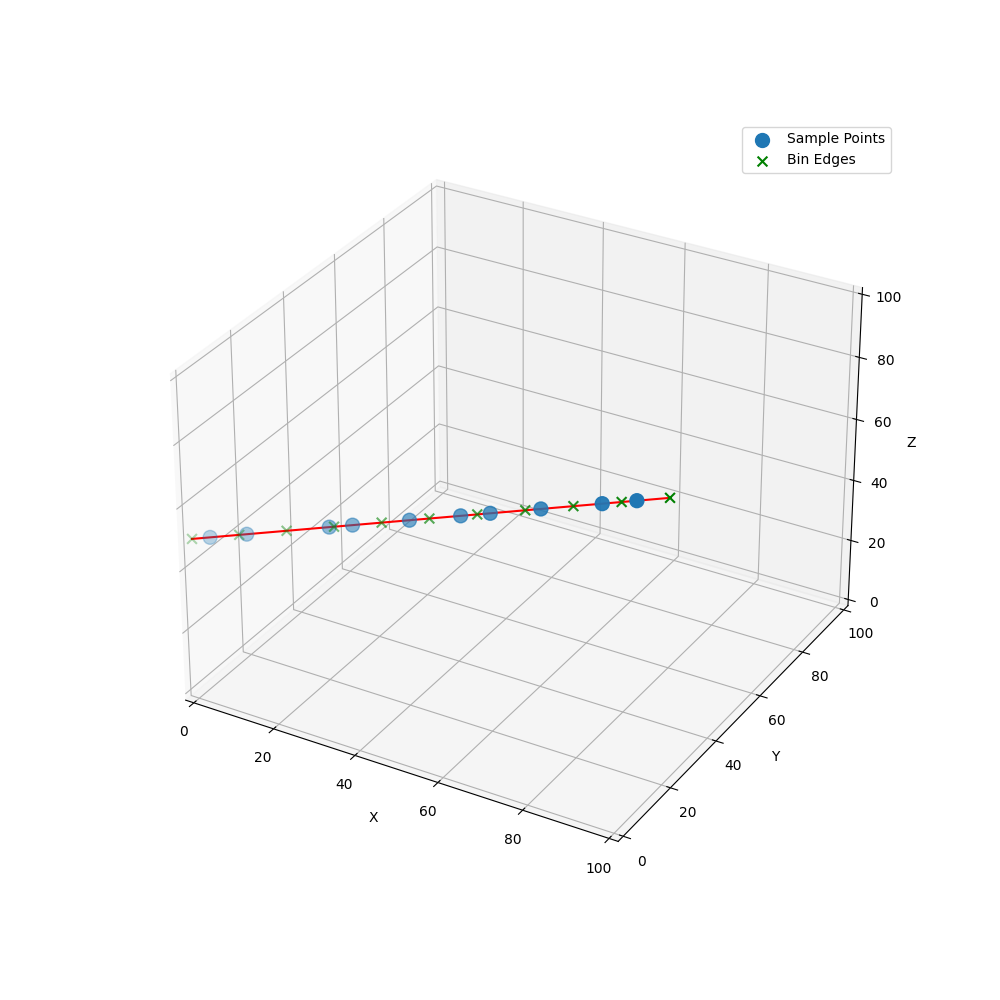

In [11]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
%matplotlib widget

def plot_sample_points(sample_points, bins):

    # Extract x, y, and z coordinates
    x = sample_points[:, 0]
    y = sample_points[:, 1]
    z = sample_points[:, 2]

    x_bins = bins[:, 0]
    y_bins = bins[:, 1]
    z_bins = bins[:, 2]

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(x, y, z, label='Sample Points', s=100)
    ax.scatter(x_bins, y_bins, z_bins, color='green', marker='x', s=50, label='Bin Edges')
    ax.plot(x_bins, y_bins, z_bins, color='red')

    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)
    ax.set_zlim(0, 100)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    ax.legend()

    plt.show()

plot_sample_points(sample_points, bins)

__The following assignement can be removed, because it is not tested, and not used in the final training__ <br>
Pierre Pujol <br>
```  TODO: Implement the function neural_radiance_volume(rays, view_dir, batch_size, nerf_model, t) that outputs (pixel_color, weights). ``` <br>

You will need to encode the rays and viewing direction(view_dir) before processing them with the NeRF model. Using batches is necessary to avoid running out of memory when processing the inputs with the NeRF model.```

In [12]:
def neural_radiance_volume(rays, view_dir, batch_size, nerf_model, t):
    # Prepare input tensors
    pos_enc_rays = get_positional_encoding(rays, L=10)
    pos_enc_view_dir = get_positional_encoding(view_dir, L=4)

    colors = []
    sigmas = []

    # Process batches of inputs to avoid running out of memory
    for i in range(0, rays.shape[0], batch_size):
        batch_rays = pos_enc_rays[i:i+batch_size]
        batch_view_dir = pos_enc_view_dir[i:i+batch_size]
        batch_t = t[i:i+batch_size]

        # Predict colors and volume densities using the NeRF model
        rgb, sigma = nerf_model(batch_rays, batch_view_dir)

        # Store predictions
        colors.append(rgb)
        sigmas.append(sigma)

    # Concatenate predictions
    colors = torch.cat(colors).reshape(rays.shape)
    sigmas = torch.cat(sigmas).reshape(rays.shape[:-1])

    # Compute the distance between each sample
    delta = t[..., 1:] - t[..., :-1]

    weights = torch.exp(-torch.sum(sigma*delta))*(1-torch.exp(-delta*sigma))
    pixel_color = torch.sum(colors*weights, dim=-1)
    
    return pixel_color , weights

#### Hierarchical sampling 

The stratified sampling strategy can be further optimize. In fact, occluded and detailed regions are equally sampled with this strategy. <br>
To favour detailed regions, samples are chosen based on their expected effect on the final rendering. The effect of a sample is estimated using an additional NErF MLP network:
- A 'coarse' network makes predictions based on stratified sampling at $N_c$ locations <br>
- A wiser sampling is derived from these predictions, biased towards locations with high intensity colors <br>
- A 'fine' network makes predictions using this hierarchical sampling at $N_f$ new locations and the previous $N_c$ locations<br>

The hierarchical sampling is based on a Probability Distribution Function that favors locations with high color intensity. <br> Rewriting the numerical color equation as a weighted sum of colors: 

$\begin{equation}
\hat{C}_{c}(r)=\sum_{i=1}^{N_{c}}w_{i}c_{i}, \quad w_{i} = T_{i}(1 - \exp(-\sigma_i\delta_i))
\end{equation}$
The PDF is obtained by normalizing the weights: $\hat{w}_{i} = \frac{w_i}{\sum_{i=1}^{N_{c}}w_{i}c_{i}} $

``` TODO: implement the hierarchical sampling ``` <br>
Amaury Giard

In [13]:
def inverse_transform_sampling(weights, Nf):
    """
        weights: A tensor of shape (..., N) representing weights.
        Nf: The number of samples to draw.

    """
    # Normalize weights
    normalized_weights = weights / weights.sum(dim=-1, keepdim=True)

    # Perform inverse transform sampling
    cdf = normalized_weights.cumsum(dim=-1)  # Cumulative distribution function
    rand_samples = torch.rand(weights.shape[:-1] + (Nf,))  # Random samples between 0 and 1

    # Invert CDF using torch.searchsorted
    sampled_locations = torch.searchsorted(cdf, rand_samples, right=True)

    return sampled_locations

In [14]:
def get_hierarchical_samples(Nf, coarse_samples, weights, direction, tn, tf, N):
    """
    Nf: number of samples to generate
    coarse_samples: samples
    weights: weights associated to coarse samples
    tn: initial t
    tf: maximal t
    N: number of bins

    Returns: all samples used to evaluate the fine network 
    """
    bin_size = (tf-tn)/N
    samples_indices = inverse_transform_sampling(weights, Nf)
    u = torch.rand(Nf)-0.5
    print(u.shape, direction.shape, (direction.unsqueeze(0)*u.unsqueeze(1)).shape)
    print(coarse_samples[samples_indices].shape)
    fine_samples = torch.clamp(coarse_samples[samples_indices][0] + bin_size*direction.unsqueeze(0)*u.unsqueeze(1), tn, tf)
    
    return torch.cat((fine_samples, coarse_samples), dim=0)

In [15]:
def plot_fine_sample_points(fine_sample_points, coarse_sample_points, bins):

    # Extract x, y, and z coordinates
    x_f = fine_sample_points[:, 0]
    y_f = fine_sample_points[:, 1]
    z_f = fine_sample_points[:, 2]

    x_c = coarse_sample_points[:, 0]
    y_c = coarse_sample_points[:, 1]
    z_c = coarse_sample_points[:, 2]

    x_bins = bins[:, 0]
    y_bins = bins[:, 1]
    z_bins = bins[:, 2]

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(x_f, y_f, z_f, label='Fine Sample Points', s=100)
    ax.scatter(x_c, y_c, z_c, label='Coarse Sample Points', s=110, color='white', edgecolors='red', linewidth=3)
    ax.scatter(x_bins, y_bins, z_bins, color='green', marker='x', s=50, label='Bin Edges')
    ax.plot(x_bins, y_bins, z_bins, color='red')

    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)
    ax.set_zlim(0, 100)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    ax.legend()

    plt.show()

torch.Size([50]) torch.Size([3]) torch.Size([50, 3])
torch.Size([1, 50, 3])


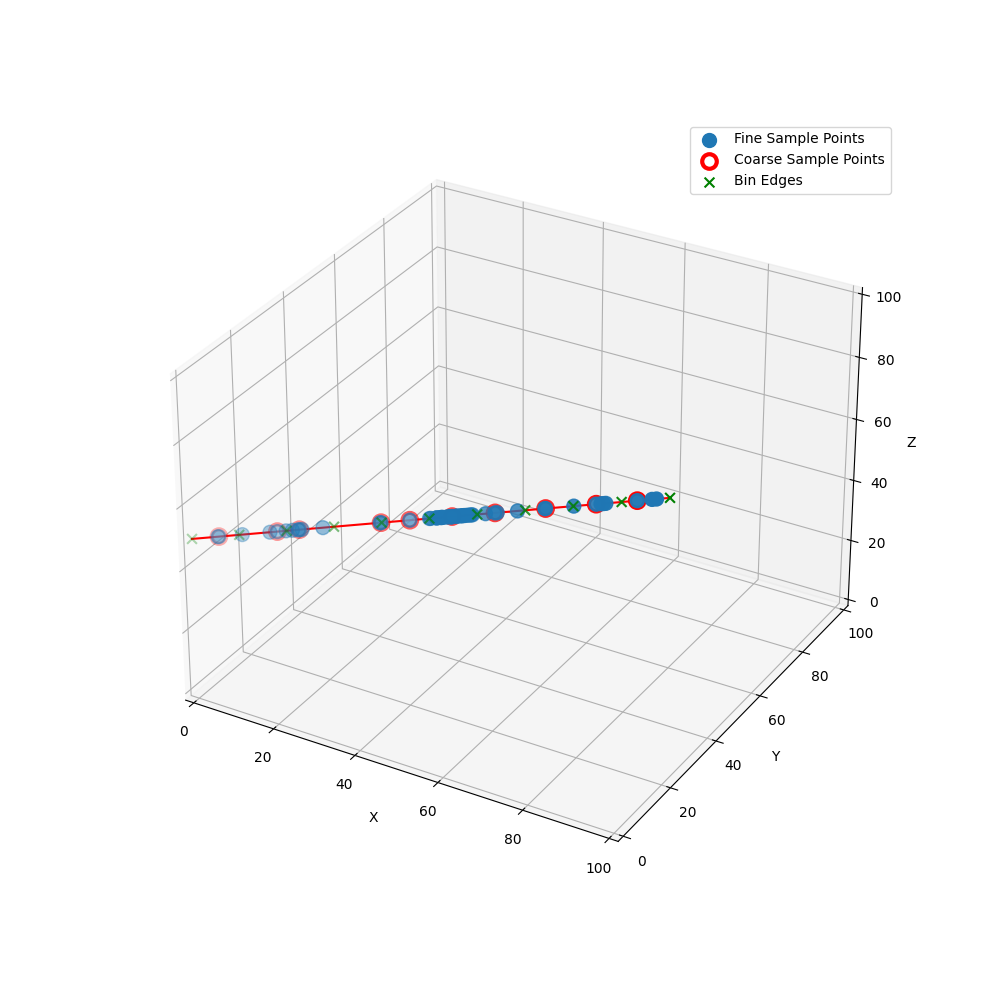

In [16]:
# Run to test your code

N = 10
tn = 0
tf = 100
O = torch.Tensor([0., 0., 50.])
u = torch.Tensor([1.0, 0.5, 0.2])
u = u/torch.sqrt(torch.sum(u ** 2))
t = get_stratified_samples(tn, tf, N)
coarse_sample_points = sample_ray(O,u,t)
bins = sample_ray(O,u,torch.arange(0,110,10))

weights = torch.ones((1,10))
weights[0, 5] = 20.

fine_sample_points = get_hierarchical_samples(50, coarse_sample_points, weights, u, tn, tf, N)
plot_fine_sample_points(fine_sample_points, coarse_sample_points, bins)

#### Training 
Victor Ludvig <br>

To train the our models, we will use an optimized batch version of the sampling functions we defined earlier. <br>
We also use an existing rendering function that renders the scene based on the radiance field. <br>
Finally, the code contains image processing functions to load the dataset views. <br>
Study the code and train your network for 1.000 iterations. <br>
Code adapted from [https://github.com/airalcorn2/pytorch-nerf/blob/master/run_nerf.py](https://github.com/airalcorn2/pytorch-nerf/blob/master/run_nerf.py)<br>

Download the dataset (if you encounter a pickle bug using wget, manually download the dataset using the URL)

In [16]:
!wget https://github.com/airalcorn2/pytorch-nerf/blob/master/66bdbc812bd0a196e194052f3f12cb2e.npz

--2024-03-27 17:26:16--  https://github.com/airalcorn2/pytorch-nerf/blob/master/66bdbc812bd0a196e194052f3f12cb2e.npz
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘66bdbc812bd0a196e194052f3f12cb2e.npz.8’

66bdbc812bd0a196e19     [   <=>              ] 265,61K   578KB/s    in 0,5s    

2024-03-27 17:26:17 (578 KB/s) - ‘66bdbc812bd0a196e194052f3f12cb2e.npz.8’ saved [271983]



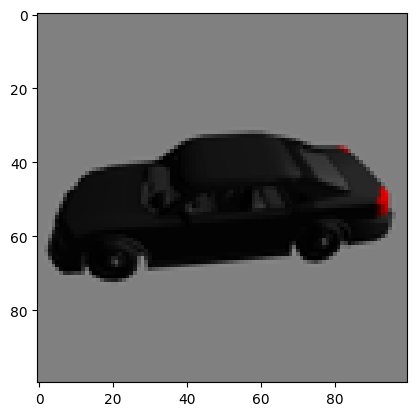

Loss: 0.05131010711193085


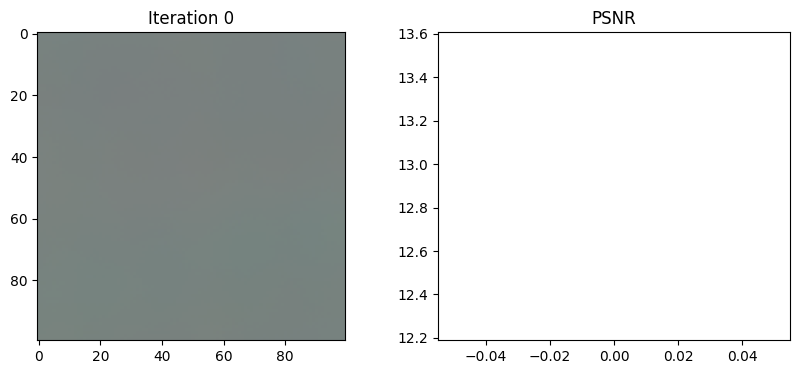

Loss: 0.016731875017285347


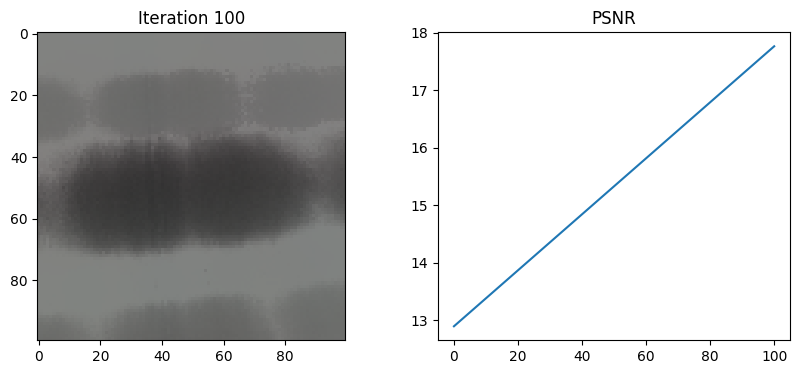

Loss: 0.01626809872686863


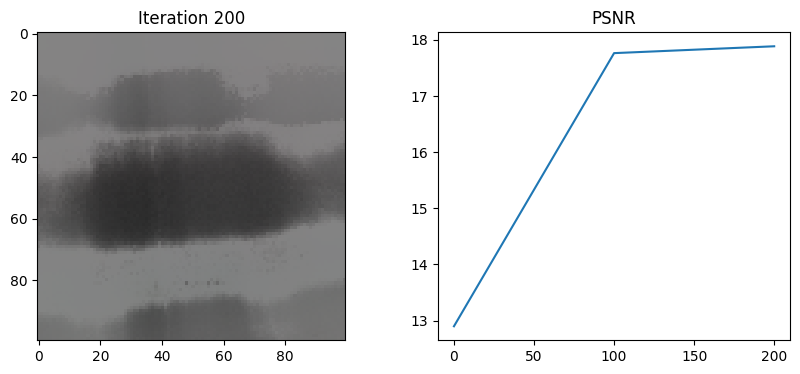

Loss: 0.014447757974267006


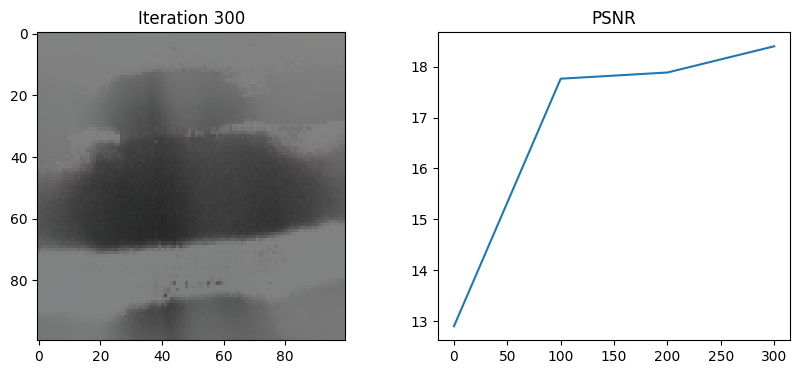

Loss: 0.01700522191822529


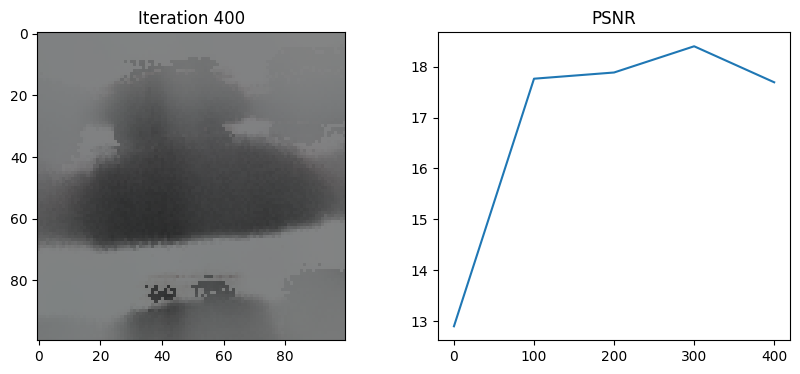

Loss: 0.014801375567913055


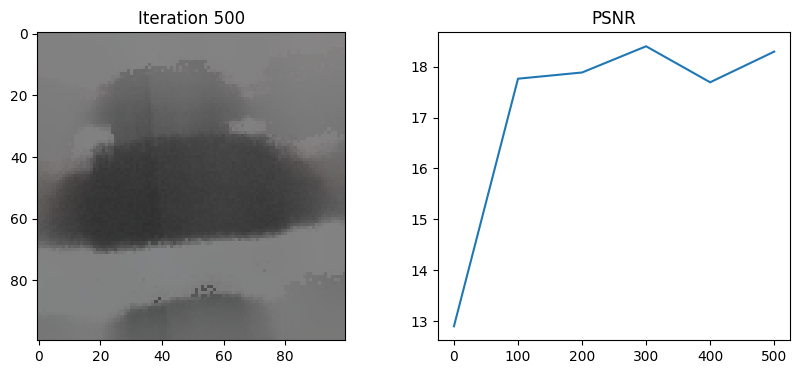

Loss: 0.01678614132106304


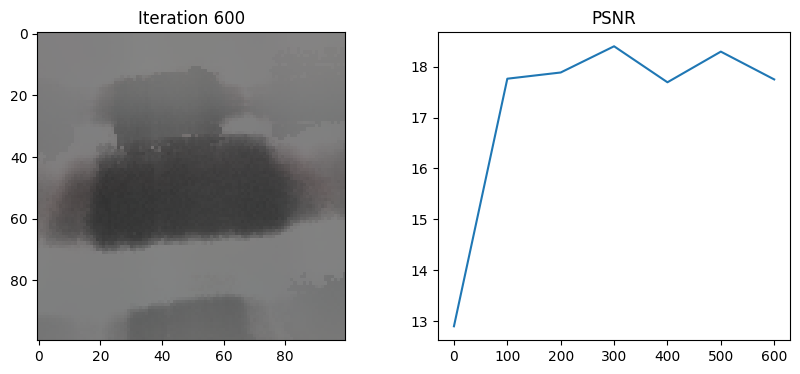

Loss: 0.013276355341076851


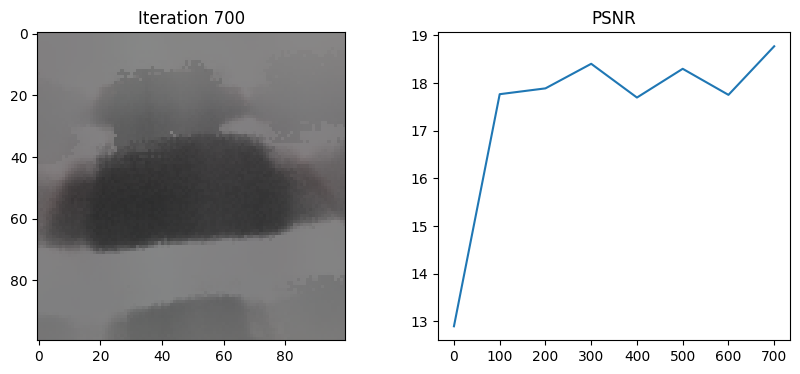

Loss: 0.01448576059192419


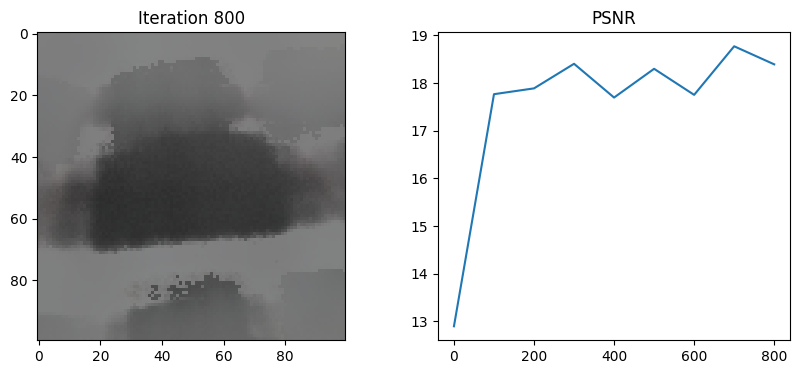

Loss: 0.01332878042012453


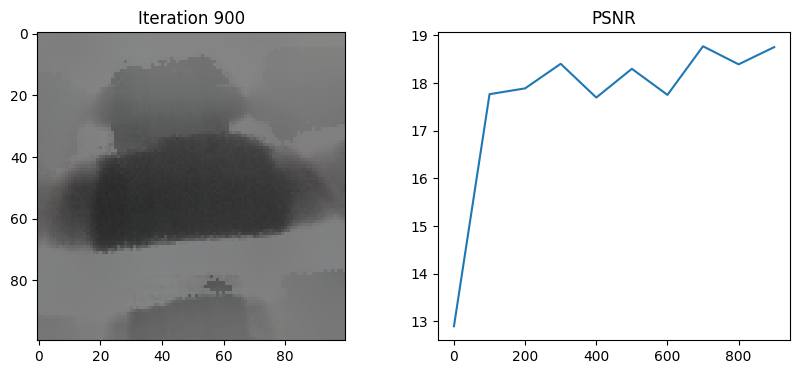

Loss: 0.010742498561739922


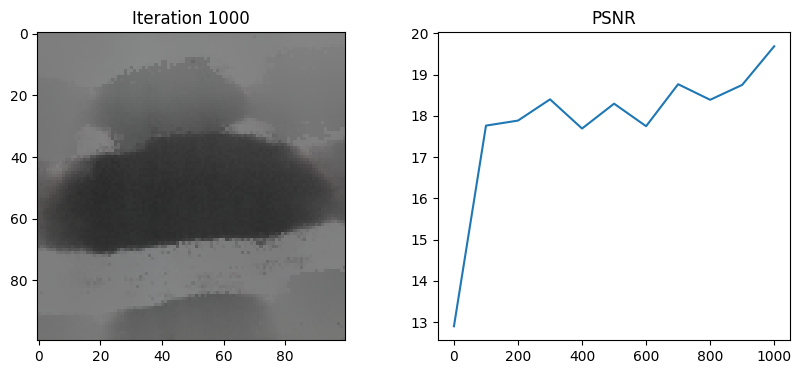

Loss: 0.011439567431807518


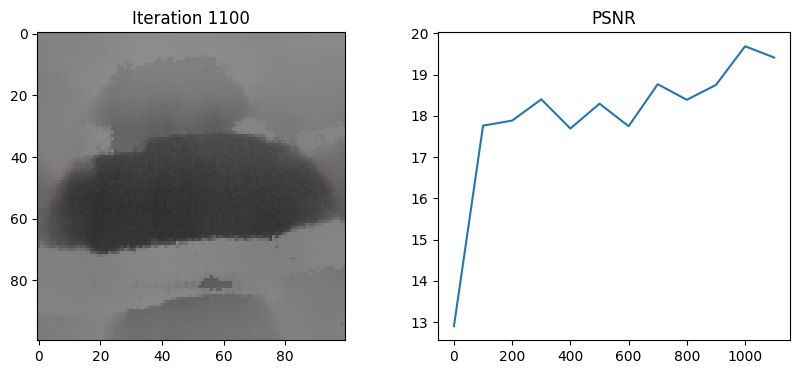

Loss: 0.015021621249616146


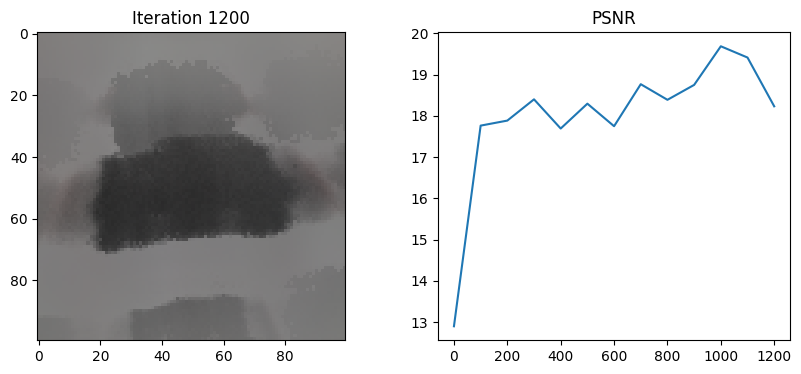

Loss: 0.01285716611891985


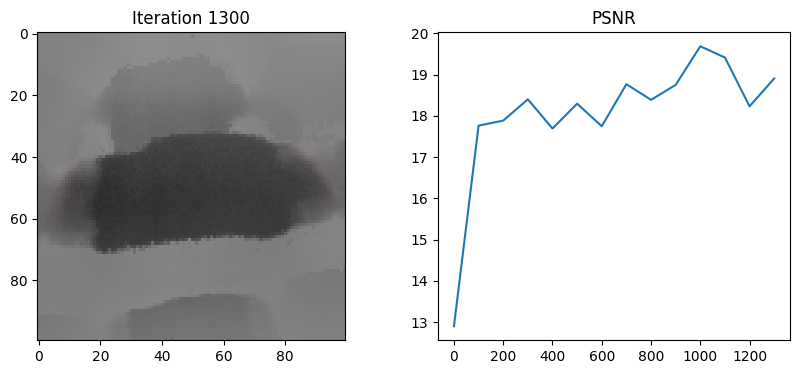

Loss: 0.010281831957399845


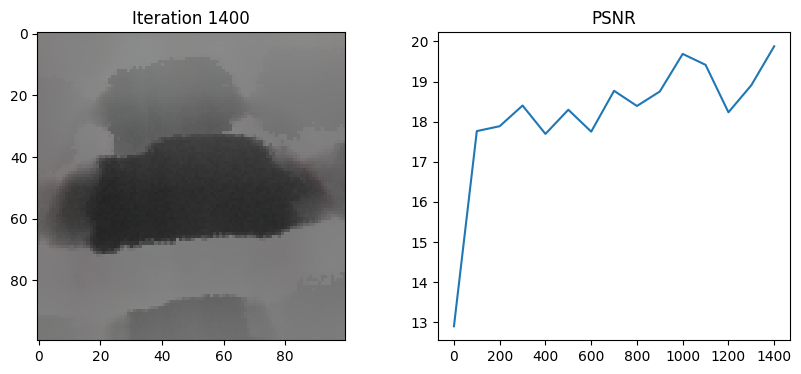

Loss: 0.008778252638876438


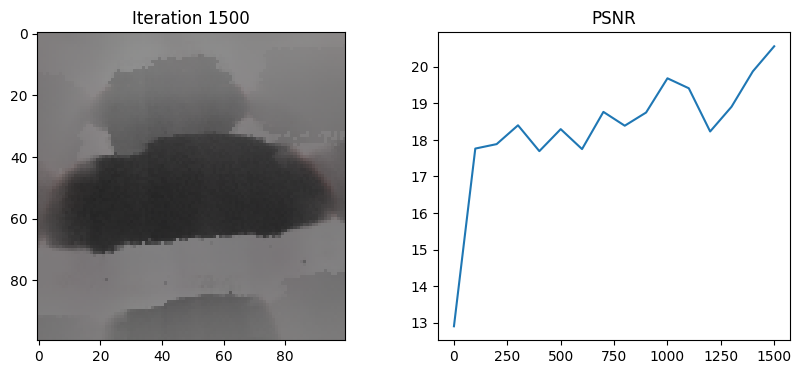

Loss: 0.009632077999413013


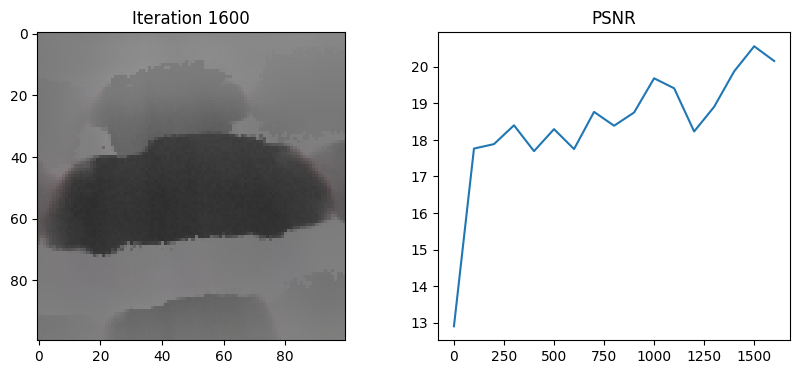

Loss: 0.014442665502429008


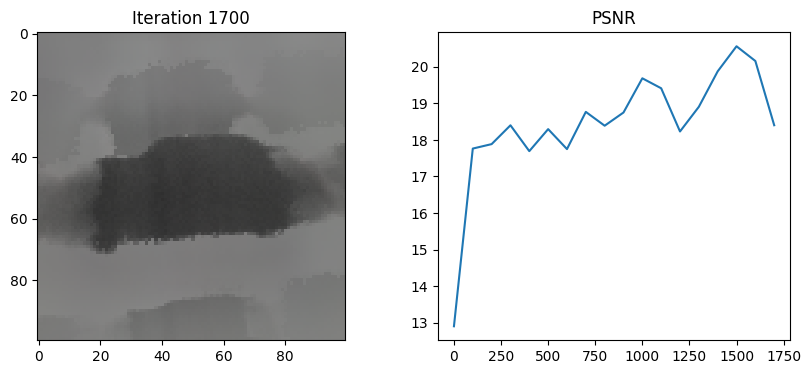

Loss: 0.009205659851431847


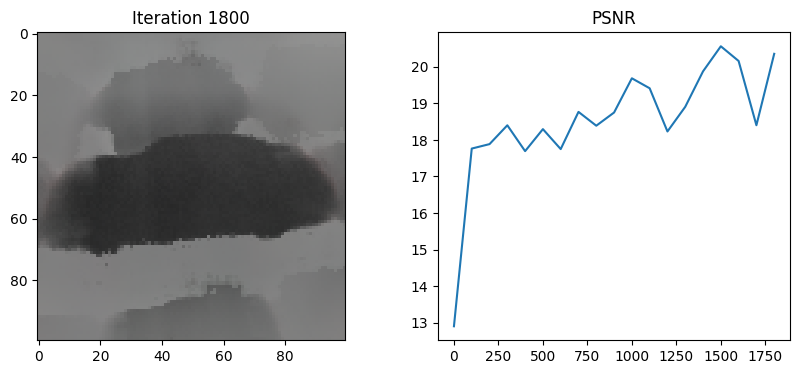

Loss: 0.014634890481829643


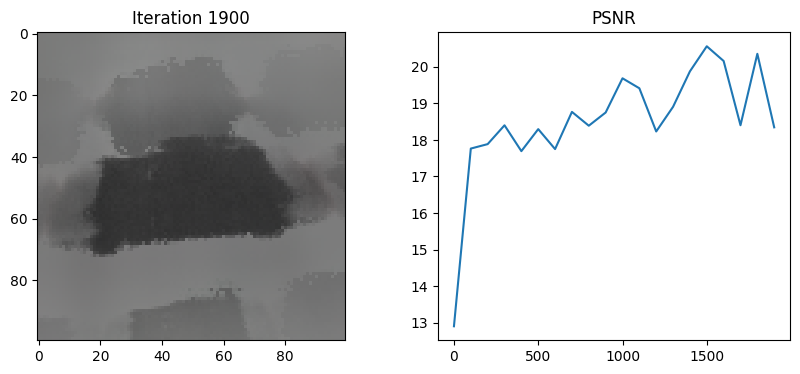

Loss: 0.011156539432704449


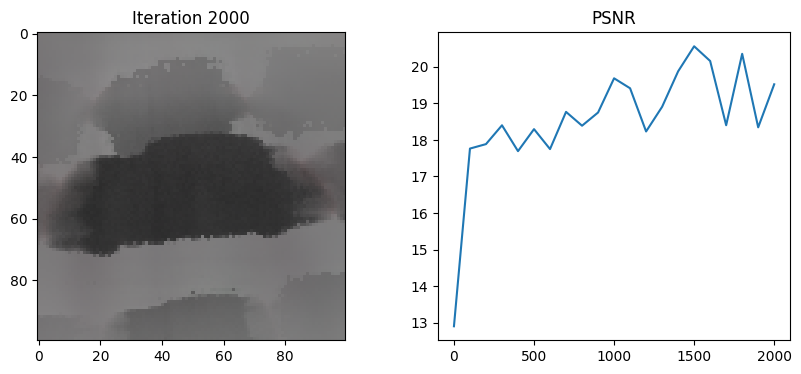

Loss: 0.011211870238184929


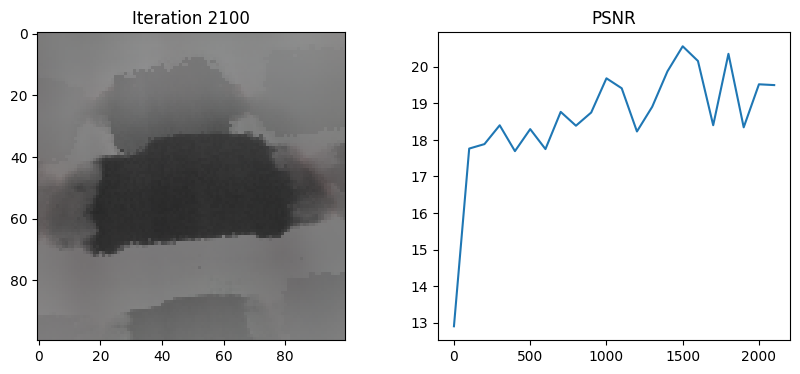

Loss: 0.00971295591443777


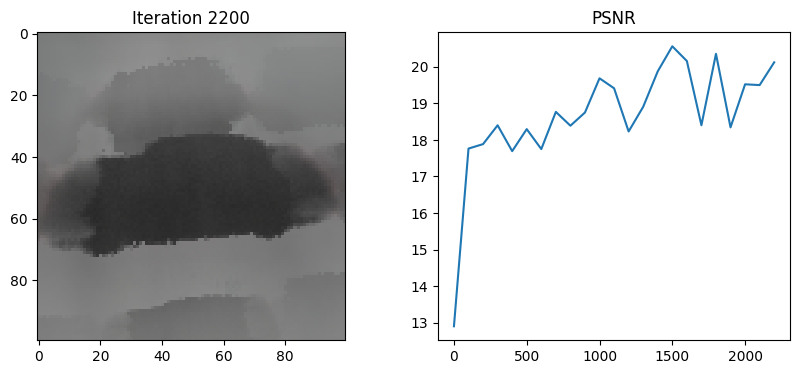

Loss: 0.008772745728492737


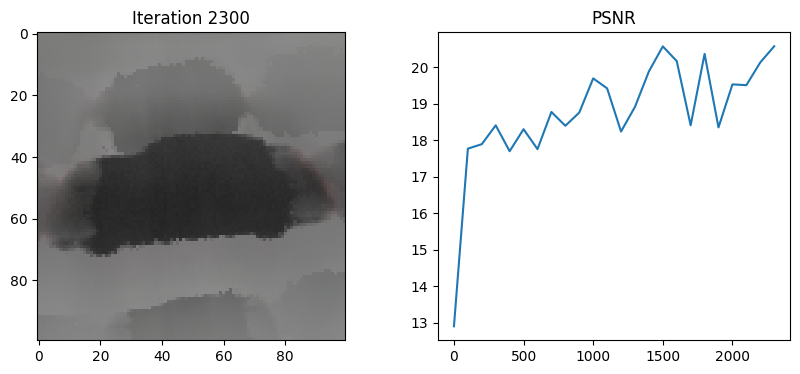

Loss: 0.009834454394876957


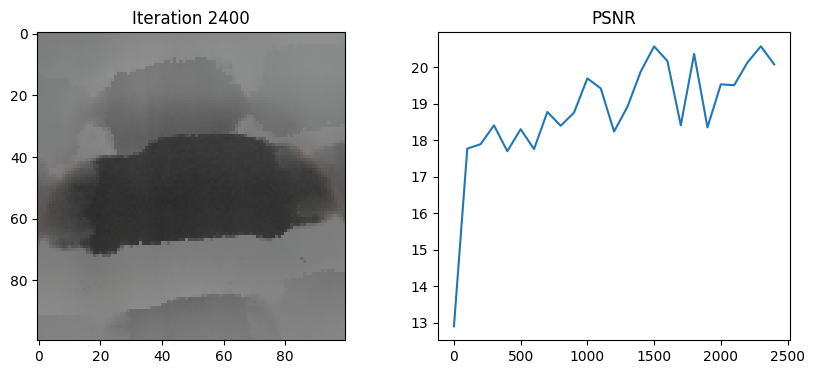

Loss: 0.009410538710653782


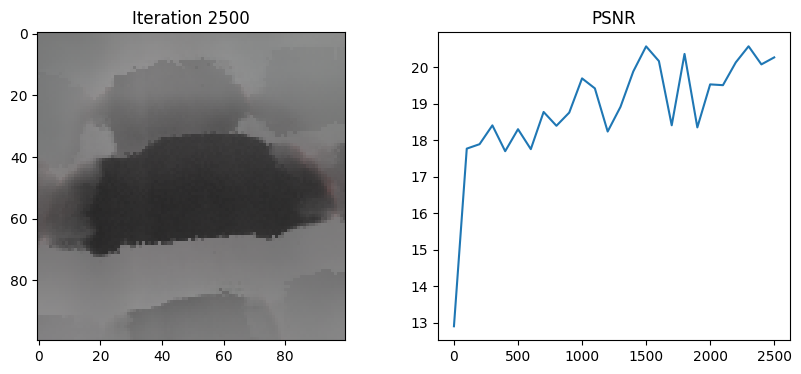

Loss: 0.011658623814582825


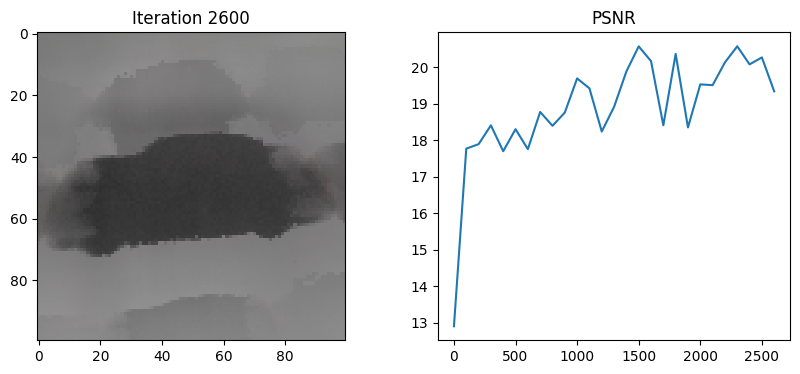

Loss: 0.01027553528547287


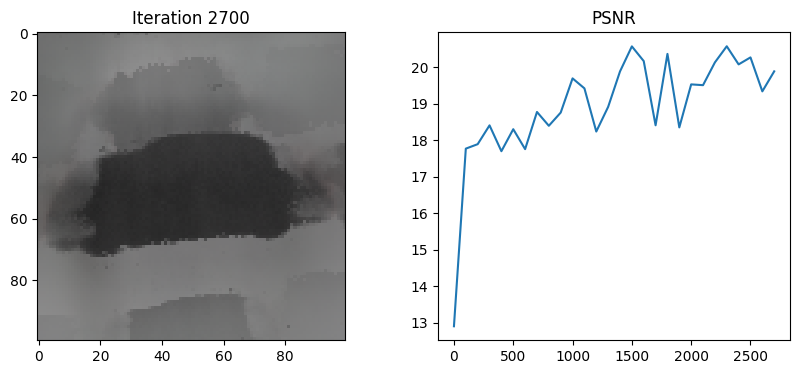

Loss: 0.011795833706855774


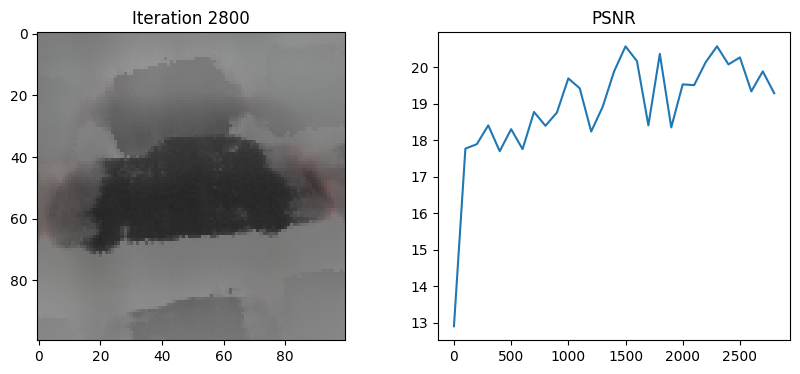

Loss: 0.009184547699987888


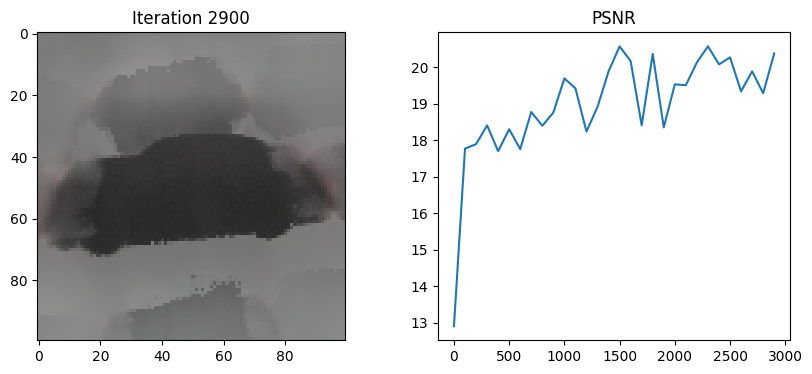

Loss: 0.008534839376807213


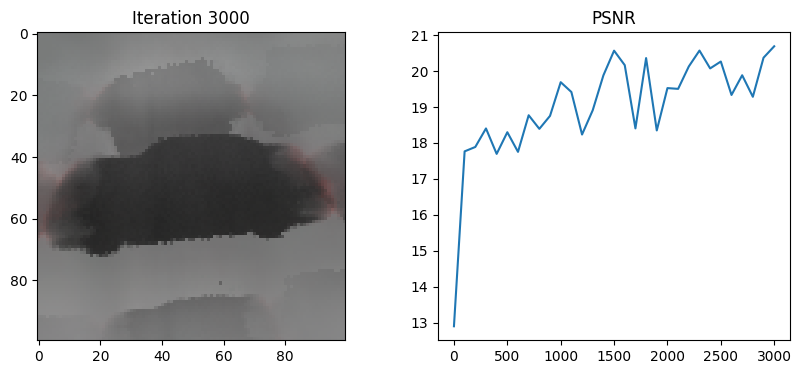

Loss: 0.009353035129606724


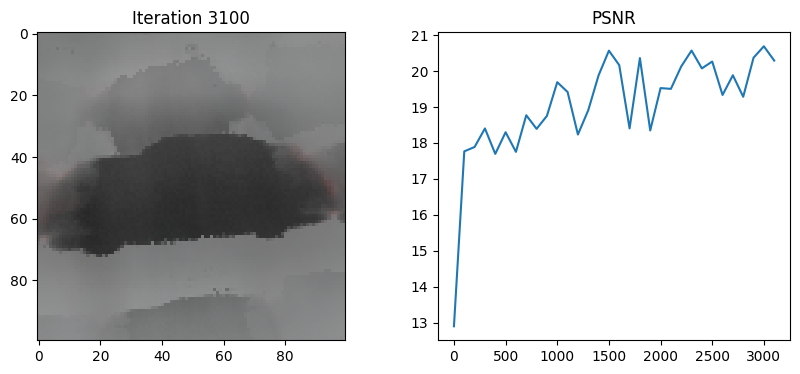

Loss: 0.008835065178573132


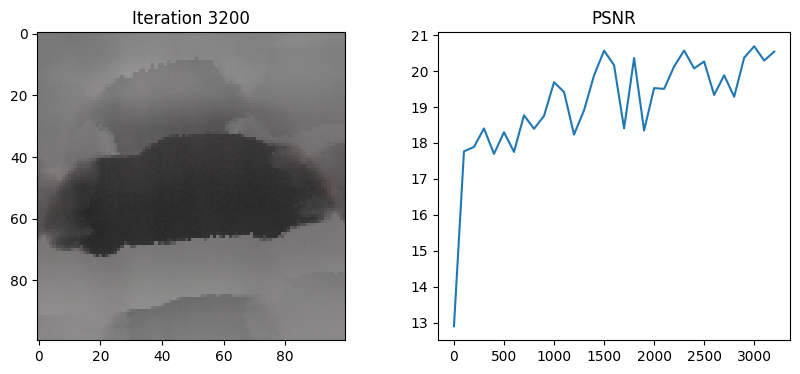

Loss: 0.01064577978104353


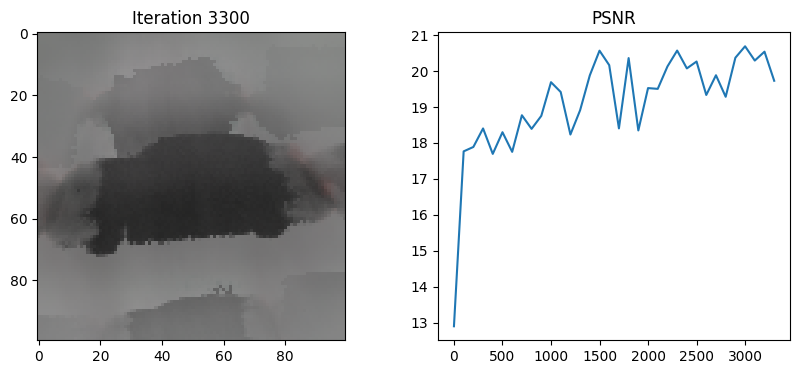

Loss: 0.010329167358577251


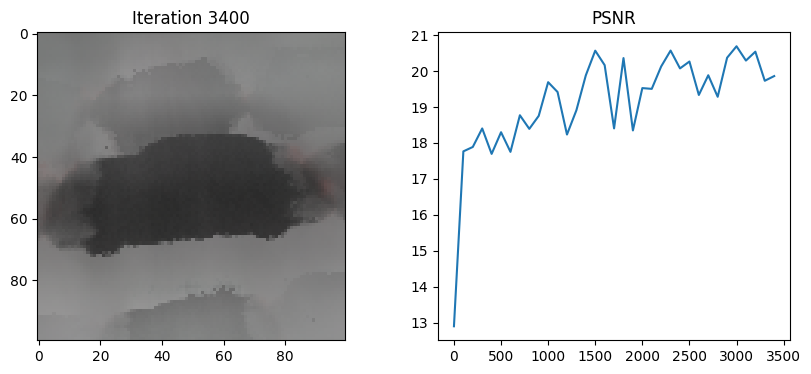

Loss: 0.011664099059998989


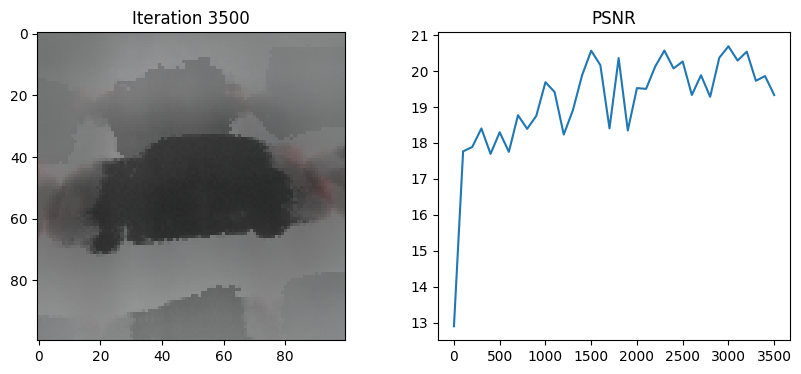

Loss: 0.009055428206920624


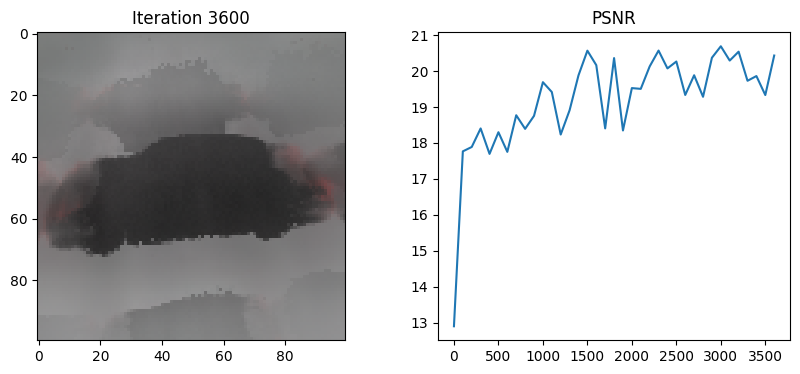

Loss: 0.008010771125555038


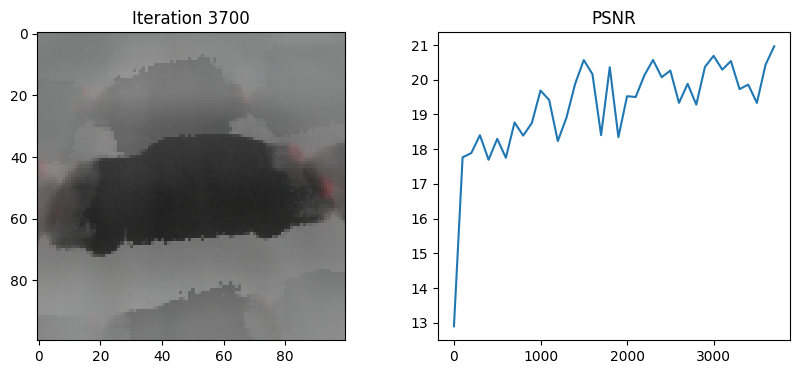

Loss: 0.008386293426156044


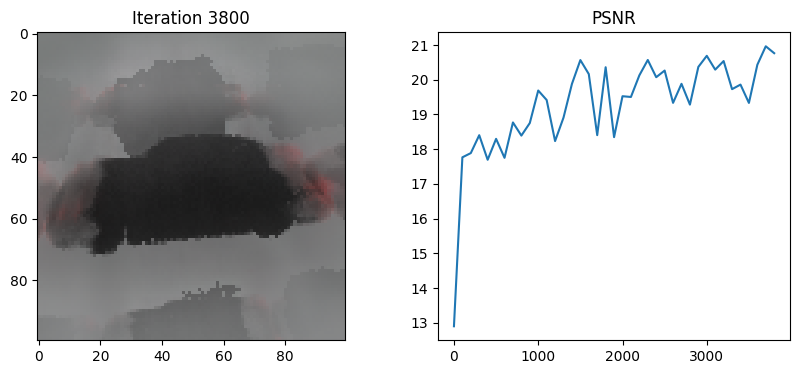

Loss: 0.00837787427008152


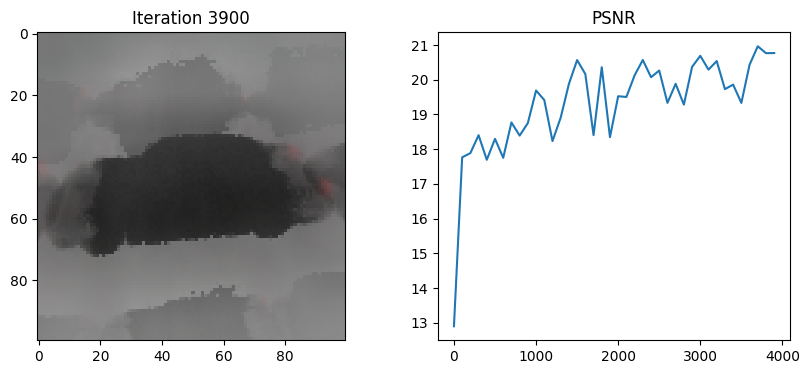

Loss: 0.007919985800981522


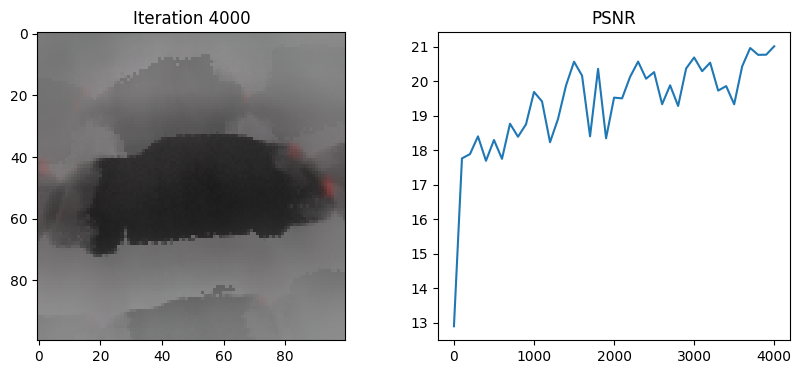

Loss: 0.007830060087144375


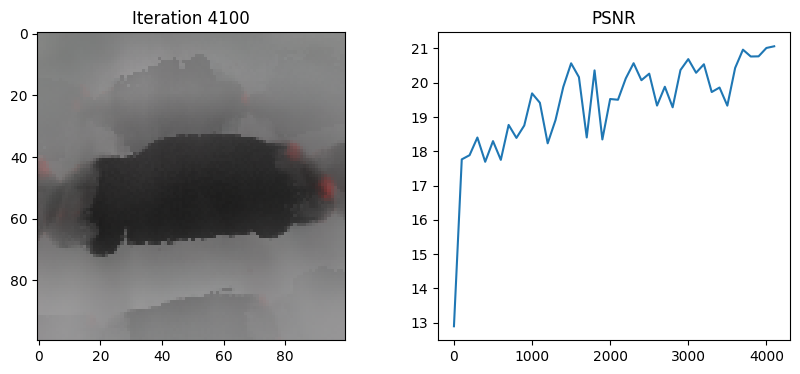

Loss: 0.009269182570278645


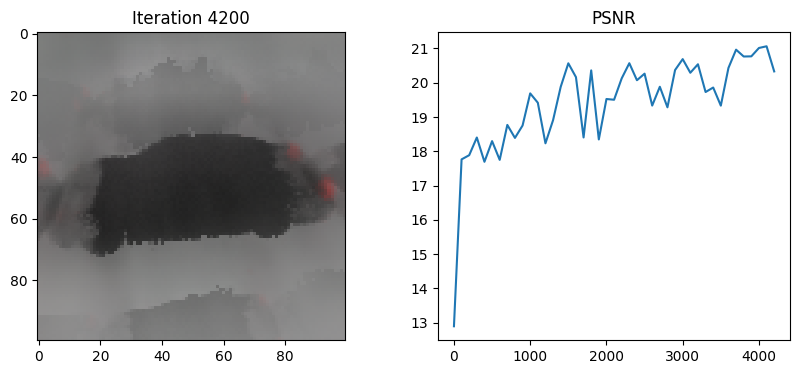

Loss: 0.007412733975797892


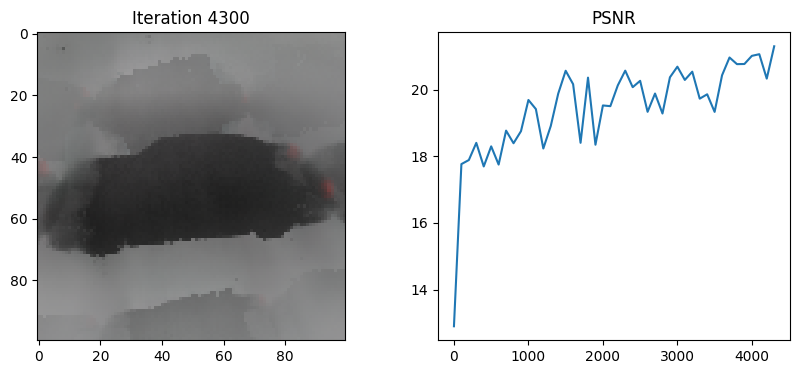

Loss: 0.007528749294579029


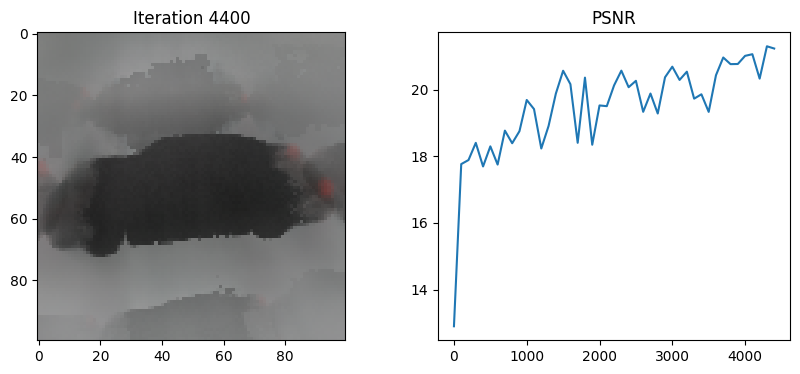

Loss: 0.011004213243722916


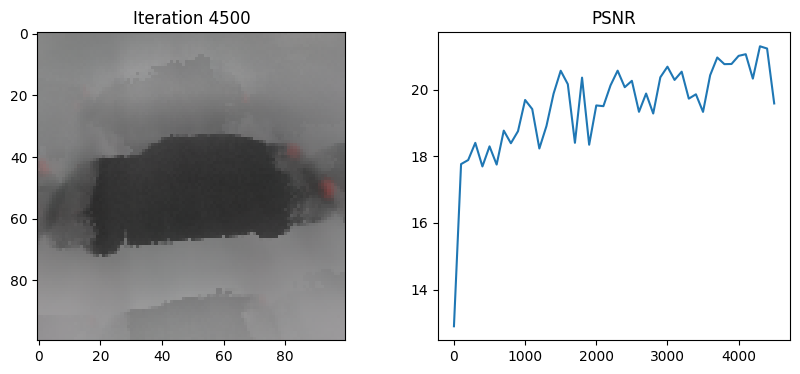

Loss: 0.008223623037338257


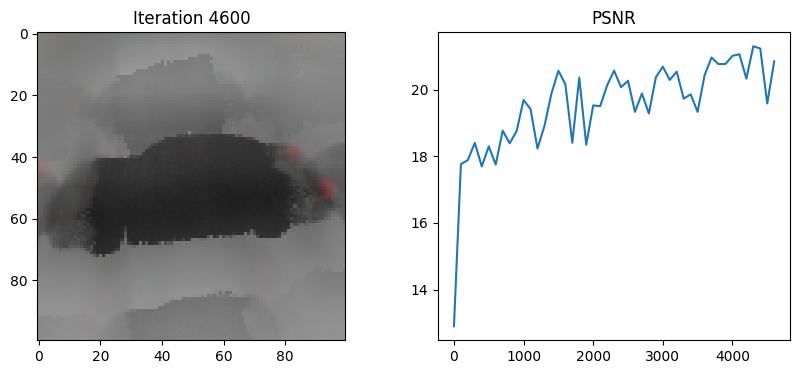

Loss: 0.0070334835909307


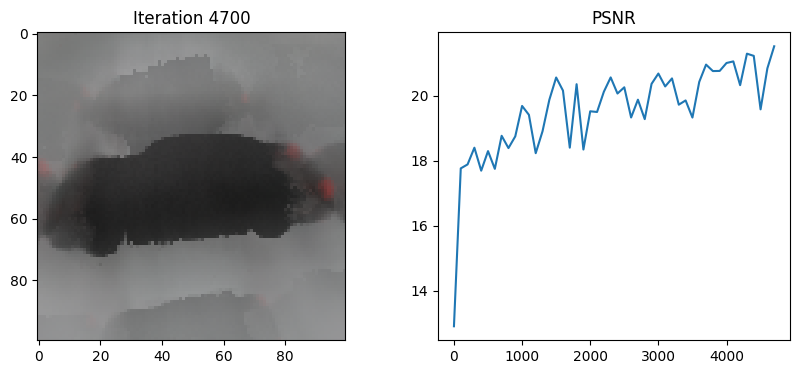

Loss: 0.007417349610477686


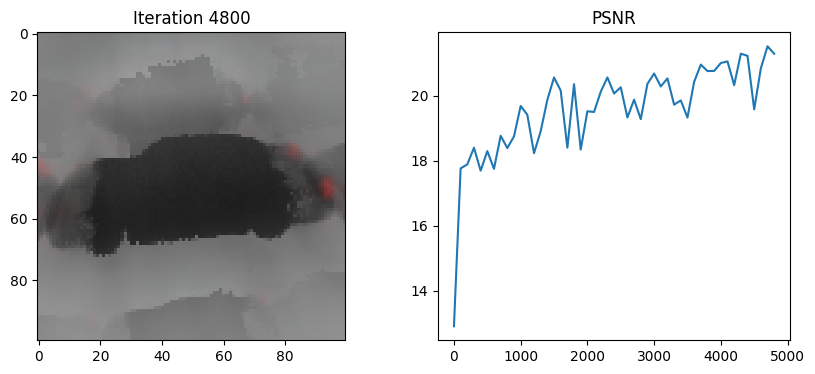

Loss: 0.0074867005459964275


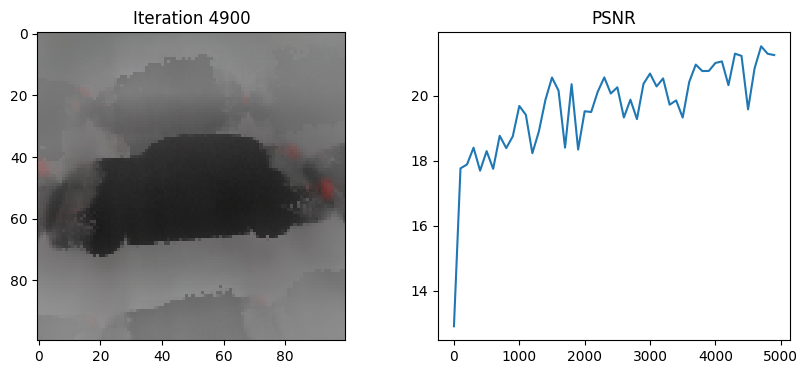

Loss: 0.0076427883468568325


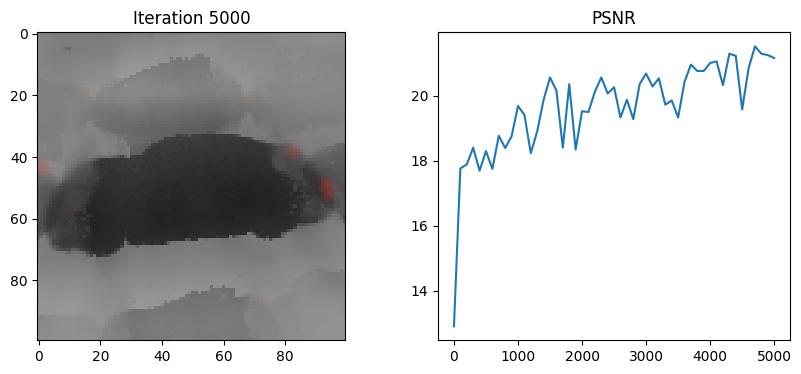

Loss: 0.007593813817948103


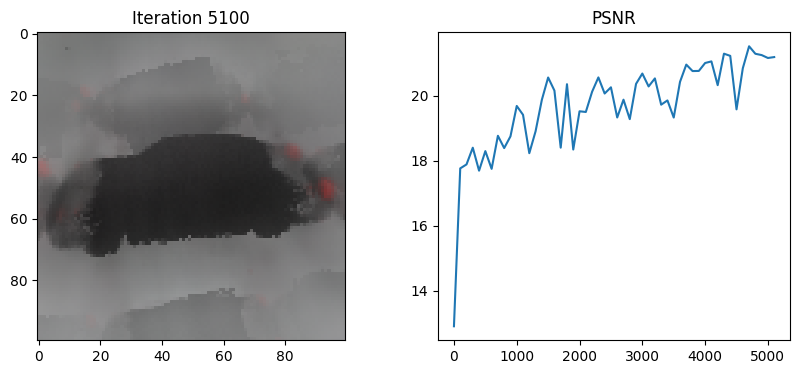

Loss: 0.006529847159981728


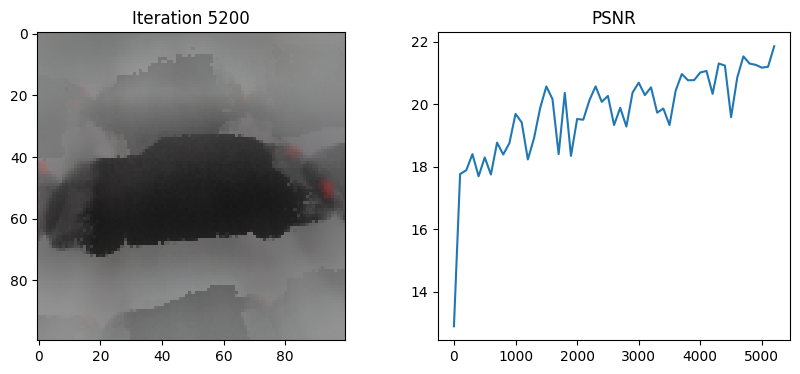

Loss: 0.006588957738131285


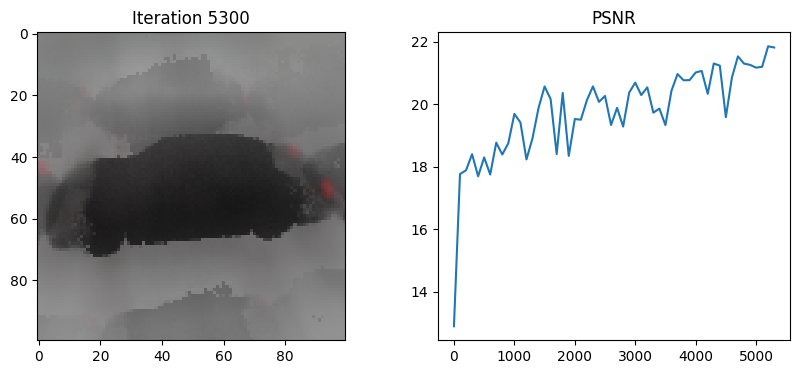

Loss: 0.007561776787042618


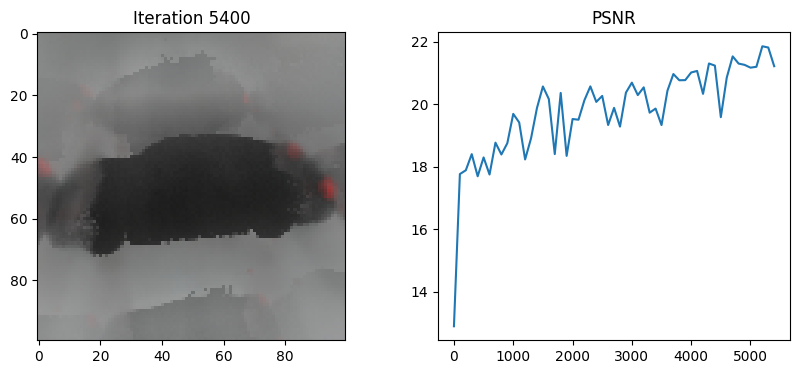

KeyboardInterrupt: 

In [15]:
import numpy as np
from torch import optim
plt.figure()
%matplotlib inline

def get_coarse_query_points(ds, N_c, t_i_c_bin_edges, t_i_c_gap, os):
    # Sample depths (t_is_c). See Equation (2) in Section 4.
    u_is_c = torch.rand(*list(ds.shape[:2]) + [N_c]).to(ds)
    t_is_c = t_i_c_bin_edges + u_is_c * t_i_c_gap
    # Calculate the points along the rays (r_ts_c) using the ray origins (os), sampled
    # depths (t_is_c), and ray directions (ds). See Section 4: r(t) = o + t * d.
    r_ts_c = os[..., None, :] + t_is_c[..., :, None] * ds[..., None, :]
    return (r_ts_c, t_is_c)


def get_fine_query_points(w_is_c, N_f, t_is_c, t_f, os, ds):
    # See text surrounding Equation (5) in Section 5.2 and:
    # https://stephens999.github.io/fiveMinuteStats/inverse_transform_sampling.html#discrete_distributions.

    # Define PDFs (pdfs) and CDFs (cdfs) from weights (w_is_c).
    w_is_c = w_is_c + 1e-5
    pdfs = w_is_c / torch.sum(w_is_c, dim=-1, keepdim=True)
    cdfs = torch.cumsum(pdfs, dim=-1)
    cdfs = torch.cat([torch.zeros_like(cdfs[..., :1]), cdfs[..., :-1]], dim=-1)

    # Get uniform samples (us).
    us = torch.rand(list(cdfs.shape[:-1]) + [N_f]).to(w_is_c)

    # Use inverse transform sampling to sample the depths (t_is_f).
    idxs = torch.searchsorted(cdfs, us, right=True)
    t_i_f_bottom_edges = torch.gather(t_is_c, 2, idxs - 1)
    idxs_capped = idxs.clone()
    max_ind = cdfs.shape[-1]
    idxs_capped[idxs_capped == max_ind] = max_ind - 1
    t_i_f_top_edges = torch.gather(t_is_c, 2, idxs_capped)
    t_i_f_top_edges[idxs == max_ind] = t_f
    t_i_f_gaps = t_i_f_top_edges - t_i_f_bottom_edges
    u_is_f = torch.rand_like(t_i_f_gaps).to(os)
    t_is_f = t_i_f_bottom_edges + u_is_f * t_i_f_gaps

    # Combine the coarse (t_is_c) and fine (t_is_f) depths and sort them.
    (t_is_f, _) = torch.sort(torch.cat([t_is_c, t_is_f.detach()], dim=-1), dim=-1)
    # Calculate the points along the rays (r_ts_f) using the ray origins (os), depths
    # (t_is_f), and ray directions (ds). See Section 4: r(t) = o + t * d.
    r_ts_f = os[..., None, :] + t_is_f[..., :, None] * ds[..., None, :]
    return (r_ts_f, t_is_f)


def render_radiance_volume(r_ts, ds, chunk_size, F, t_is):
    # Use the network (F) to predict colors (c_is) and volume densities (sigma_is) for
    # 3D points along rays (r_ts) given the viewing directions (ds) of the rays. See
    # Section 3 and Figure 7 in the Supplementary Materials.
    r_ts_flat = r_ts.reshape((-1, 3))
    ds_rep = ds.unsqueeze(2).repeat(1, 1, r_ts.shape[-2], 1)
    ds_flat = ds_rep.reshape((-1, 3))
    c_is = []
    sigma_is = []
    # The network processes batches of inputs to avoid running out of memory.
    for chunk_start in range(0, r_ts_flat.shape[0], chunk_size):
        r_ts_batch = r_ts_flat[chunk_start : chunk_start + chunk_size]
        ds_batch = ds_flat[chunk_start : chunk_start + chunk_size]
        preds = F(r_ts_batch, ds_batch)
        c_is.append(preds[0])
        sigma_is.append(preds[1])
        # c_is.append(preds['c_is'])
        # sigma_is.append(preds['sigma_is'])

    c_is = torch.cat(c_is).reshape(r_ts.shape)
    sigma_is = torch.cat(sigma_is).reshape(r_ts.shape[:-1])

    # Calculate the distances (delta_is) between points along the rays. The differences
    # in depths are scaled by the norms of the ray directions to get the final
    # distances. See text following Equation (3) in Section 4.
    delta_is = t_is[..., 1:] - t_is[..., :-1]
    # "Infinity". Guarantees last alpha is always one.
    one_e_10 = torch.Tensor([1e10]).expand(delta_is[..., :1].shape)
    delta_is = torch.cat([delta_is, one_e_10.to(delta_is)], dim=-1)
    delta_is = delta_is * ds.norm(dim=-1).unsqueeze(-1)

    # Calculate the alphas (alpha_is) of the 3D points using the volume densities
    # (sigma_is) and distances between points (delta_is). See text following Equation
    # (3) in Section 4 and https://en.wikipedia.org/wiki/Alpha_compositing.
    alpha_is = 1.0 - torch.exp(-sigma_is * delta_is)

    # Calculate the accumulated transmittances (T_is) along the rays from the alphas
    # (alpha_is). See Equation (3) in Section 4. T_i is "the probability that the ray
    # travels from t_n to t_i without hitting any other particle".
    T_is = torch.cumprod(1.0 - alpha_is + 1e-10, -1)
    # Guarantees the ray makes it at least to the first step. See:
    # https://github.com/bmild/nerf/blob/18b8aebda6700ed659cb27a0c348b737a5f6ab60/run_nerf.py#L142,
    # which uses tf.math.cumprod(1.-alpha + 1e-10, axis=-1, exclusive=True).
    T_is = torch.roll(T_is, 1, -1)
    T_is[..., 0] = 1.0

    # Calculate the weights (w_is) for the colors (c_is) along the rays using the
    # transmittances (T_is) and alphas (alpha_is). See Equation (5) in Section 5.2:
    # w_i = T_i * (1 - exp(-sigma_i * delta_i)).
    w_is = T_is * alpha_is

    # Calculate the pixel colors (C_rs) for the rays as weighted (w_is) sums of colors
    # (c_is). See Equation (5) in Section 5.2: C_c_hat(r) = Σ w_i * c_i.
    C_rs = (w_is[..., None] * c_is).sum(dim=-2)

    return (C_rs, w_is)


def run_one_iter_of_nerf(
    ds, N_c, t_i_c_bin_edges, t_i_c_gap, os, chunk_size, F_c, N_f, t_f, F_f
):
    (r_ts_c, t_is_c) = get_coarse_query_points(ds, N_c, t_i_c_bin_edges, t_i_c_gap, os)
    (C_rs_c, w_is_c) = render_radiance_volume(r_ts_c, ds, chunk_size, F_c, t_is_c)

    (r_ts_f, t_is_f) = get_fine_query_points(w_is_c, N_f, t_is_c, t_f, os, ds)
    (C_rs_f, _) = render_radiance_volume(r_ts_f, ds, chunk_size, F_f, t_is_f)

    return (C_rs_c, C_rs_f)


def main():
    plt.close('all')
    # Set seed.
    seed = 9458
    torch.manual_seed(seed)
    np.random.seed(seed)

    # Initialize coarse and fine MLPs.
    device = "cuda:0"
    F_c = NeRF(d_position=10, d_direction=4, n_channels=256, positional_encoder=get_positional_encoding).to(device)
    F_f = NeRF(d_position=10, d_direction=4, n_channels=256, positional_encoder=get_positional_encoding).to(device)

    # Number of query points passed through the MLP at a time. See: https://github.com/bmild/nerf/blob/18b8aebda6700ed659cb27a0c348b737a5f6ab60/run_nerf.py#L488.
    chunk_size = 1024 * 32
    # Number of training rays per iteration. See Section 5.3.
    batch_img_size = 64
    n_batch_pix = batch_img_size**2

    # Initialize optimizer. See Section 5.3.
    lr = 5e-4
    optimizer = optim.Adam(list(F_c.parameters()) + list(F_f.parameters()), lr=lr)
    criterion = nn.MSELoss()
    # The learning rate decays exponentially. See Section 5.3
    # See: https://github.com/bmild/nerf/blob/18b8aebda6700ed659cb27a0c348b737a5f6ab60/run_nerf.py#L486.
    lrate_decay = 250
    decay_steps = lrate_decay * 1000
    # See: https://github.com/bmild/nerf/blob/18b8aebda6700ed659cb27a0c348b737a5f6ab60/run_nerf.py#L707.
    decay_rate = 0.1

    # Load dataset.
    data_f = "66bdbc812bd0a196e194052f3f12cb2e.npz"
    data = np.load(data_f)

    # Set up initial ray origin (init_o) and ray directions (init_ds). These are the
    # same across samples, we just rotate them based on the orientation of the camera.
    # See Section 4.
    images = data["images"] / 255
    img_size = images.shape[1]
    xs = torch.arange(img_size) - (img_size / 2 - 0.5)
    ys = torch.arange(img_size) - (img_size / 2 - 0.5)
    (xs, ys) = torch.meshgrid(xs, -ys, indexing="xy")
    focal = float(data["focal"])
    pixel_coords = torch.stack([xs, ys, torch.full_like(xs, -focal)], dim=-1)
    # We want the zs to be negative ones, so we divide everything by the focal length
    # (which is in pixel units).
    camera_coords = pixel_coords / focal
    init_ds = camera_coords.to(device)
    init_o = torch.Tensor(np.array([0, 0, float(data["camera_distance"])])).to(device)

    # Set up test view.
    test_idx = 150
    plt.figure()
    plt.imshow(images[test_idx])
    plt.show()
    test_img = torch.Tensor(images[test_idx]).to(device)
    poses = data["poses"]
    test_R = torch.Tensor(poses[test_idx, :3, :3]).to(device)
    test_ds = torch.einsum("ij,hwj->hwi", test_R, init_ds)
    test_os = (test_R @ init_o).expand(test_ds.shape)

    # Initialize volume rendering hyperparameters.
    # Near bound. See Section 4.
    t_n = 1.0
    # Far bound. See Section 4.
    t_f = 4.0
    # Number of coarse samples along a ray. See Section 5.3.
    N_c = 64
    # Number of fine samples along a ray. See Section 5.3.
    N_f = 128
    # Bins used to sample depths along a ray. See Equation (2) in Section 4.
    t_i_c_gap = (t_f - t_n) / N_c
    t_i_c_bin_edges = (t_n + torch.arange(N_c) * t_i_c_gap).to(device)

    # Start training model.
    train_idxs = np.arange(len(images)) != test_idx
    images = torch.Tensor(images[train_idxs])
    poses = torch.Tensor(poses[train_idxs])
    n_pix = img_size**2
    pixel_ps = torch.full((n_pix,), 1 / n_pix).to(device)
    psnrs = []
    iternums = []
    # See Section 5.3.
    num_iters = 300000
    display_every = 100
    F_c.train()
    F_f.train()
    for i in range(num_iters):
        # Sample image and associated pose.
        target_img_idx = np.random.randint(images.shape[0])
        target_pose = poses[target_img_idx].to(device)
        R = target_pose[:3, :3]

        # Get rotated ray origins (os) and ray directions (ds). See Section 4.
        ds = torch.einsum("ij,hwj->hwi", R, init_ds)
        os = (R @ init_o).expand(ds.shape)

        # Sample a batch of rays.
        pix_idxs = pixel_ps.multinomial(n_batch_pix, False)
        pix_idx_rows = pix_idxs // img_size
        pix_idx_cols = pix_idxs % img_size
        ds_batch = ds[pix_idx_rows, pix_idx_cols].reshape(
            batch_img_size, batch_img_size, -1
        )
        os_batch = os[pix_idx_rows, pix_idx_cols].reshape(
            batch_img_size, batch_img_size, -1
        )

        # Run NeRF.
        # ds: directions
        (C_rs_c, C_rs_f) = run_one_iter_of_nerf(
            ds_batch,
            N_c,
            t_i_c_bin_edges,
            t_i_c_gap,
            os_batch,
            chunk_size,
            F_c,
            N_f,
            t_f,
            F_f,
        )
        target_img = images[target_img_idx].to(device)
        target_img_batch = target_img[pix_idx_rows, pix_idx_cols].reshape(C_rs_f.shape)
        # Calculate the mean squared error for both the coarse and fine MLP models and
        # update the weights. See Equation (6) in Section 5.3.
        loss = criterion(C_rs_c, target_img_batch) + criterion(C_rs_f, target_img_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Exponentially decay learning rate. See Section 5.3 and:
        # https://keras.io/api/optimizers/learning_rate_schedules/exponential_decay/.
        for g in optimizer.param_groups:
            g["lr"] = lr * decay_rate ** (i / decay_steps)

        if i % display_every == 0:
            F_c.eval()
            F_f.eval()
            with torch.no_grad():
                (_, C_rs_f) = run_one_iter_of_nerf(
                    test_ds,
                    N_c,
                    t_i_c_bin_edges,
                    t_i_c_gap,
                    test_os,
                    chunk_size,
                    F_c,
                    N_f,
                    t_f,
                    F_f,
                )

            loss = criterion(C_rs_f, test_img)
            print(f"Loss: {loss.item()}")
            psnr = -10.0 * torch.log10(loss)

            psnrs.append(psnr.item())
            iternums.append(i)

            plt.figure(figsize=(10, 4))
            plt.subplot(121)
            plt.imshow(C_rs_f.detach().cpu().numpy())
            plt.title(f"Iteration {i}")
            plt.subplot(122)
            plt.plot(iternums, psnrs)
            plt.title("PSNR")
            plt.show()

            F_c.train()
            F_f.train()

    print("Done!")


if __name__ == "__main__":
    main()
